## Marcos Rigol 2010 PRE L=15 NN

In [2]:
using QuantumOptics
using Plots
using Arpack
using ArnoldiMethod
using DelimitedFiles
using LaTeXStrings
using LinearAlgebra
using Statistics
pyplot()

Plots.PyPlotBackend()

### Set up the basis
We start by setting up the basis. We have `Nparticles` living on `Nsites`, and we use the QuantumOptics function `NLevelBasis()` to account for our sites. Each site is one level, which can be occupied by as many particles as we want (since we're dealing with bosons). For the basis size this is a little troublesome, since it leads to a large number of basis states. 

In [95]:
Nsites = 15                              # Actual number of physical sites is half this, we encode particle types at different sites
Nparticles = 5                     # To define the rotated state we initially need double the number of particles
a = NLevelBasis(Nsites)
a_mb = ManyBodyBasis(a, fermionstates(a, Nparticles))
Dim=size(a_mb.occupations)[1]; # Dimension of the Hilbert Space

The many-body basis is spanned by the different occupations on every site. We can inspect the occupation numbers:

In [96]:
a_mb.occupations;

### Set up the Hamiltonian

https://www.yu.edu/sites/default/files/legacy//uploadedFiles/Faculty/Lea_Ferreira_dos_Santos/Computer_Codes/Izmir2014_04(2).pdf
p.17-25

The initial Hamiltonian contains two terms, a tunneling term, and an on-site interaction term, respectively. If we express all energies in units of the tunneling rate $t$ the only free parameter is the on-site interaction $U$:
$$
 \mathcal{H}= 
 \sum_{i=1}^{L-1}\left[-t\left(f_i^{\dagger} f_{i+1}+h . c .\right)+V\left(n_i^f-\frac{1}{2}\right)\left(n_{i+1}^f-\frac{1}{2}\right)\right. 
 \left.\right] .
$$

This equation is exactly the same as XXZ model:
$$
\mathcal{H} =\sum_{j=1}^{L-1} J_x\left(\sigma_j^x \sigma_{j+1}^x+\sigma_j^y \sigma_{j+1}^y\right)+J_z \sigma_j^z \sigma_{j+1}^z
$$

The two matrices are the same when $t=J_x/2$, $V=J_z$ up to an identical matrix.



In [97]:
NN_tunnel = [transition(a, i, i+1) for i in 1 : (Nsites-1)]
NN_tunnel = [dagger.(NN_tunnel); NN_tunnel]
total_NNtun = sum([manybodyoperator(a_mb, t) for t in NN_tunnel]);

In [9]:
NN_interaction = sum( [ (number(a_mb, i)- 0.5*identityoperator(a_mb)) * (number(a_mb, i+1) - 0.5*identityoperator(a_mb)) for i in 1:(Nsites-1) ] )
imp=number(a_mb, Int(floor(Nsites/2)))

Operator(dim=3003x3003)
  basis: ManyBody(onebodybasis=NLevel(N=15), states:3003)sparse([3, 13, 22, 31, 32, 33, 34, 35, 36, 37  …  2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947], [3, 13, 22, 31, 32, 33, 34, 35, 36, 37  …  2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947], ComplexF64[1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im  …  1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im], 3003, 3003)

### Define Hamiltonian with NNtun and NNint

The next block defines several function:
1. XX and XXZ model Hamiltonian (open boundary)
2. The process of throwing away 10% of the eigenenergies on the edge and rescale the level spacing by 'unfolding process'.
3. The standard Poisson and Wigner-Dyson distribution.

In [92]:
H(Δ) = -1*total_NNtun+Δ*NN_interaction
function Spec_fil(Energy_Spectrum)
    E_Spacing = [(Energy_Spectrum[i]-Energy_Spectrum[i-1]) for i in 2 : (Dim)];
    deleteat!(E_Spacing,1:1:Int(floor(0.05*Dim)));
    deleteat!(E_Spacing,length(E_Spacing)-Int(floor(0.05*Dim)):1:length(E_Spacing));  # Throw away the edge of spectrum
    F_Spacing=zeros(length(E_Spacing))
    for j in 1:10:(length(E_Spacing)-10)
        Avg_j=sum(E_Spacing[j:1:j+9])/10
        for i in 0:1:9
            F_Spacing[j+i]=E_Spacing[j+i]/Avg_j
        end
    end   # Unfold the spectrum by calculating the ratio between a specific space and a '10 sites' local spacing. 
    return F_Spacing
end
Poisson(x)=exp.(-x)
WDdist(x)=pi/2*x*exp.(-pi/4*x.^2);



The next few blocks solve the Exercise 8 in Lea Santo's pdf. As we can see, when the system has too much degeneracies like H(0) and H(1), the level spacing has a large distribution around 0. Otherwise, this integrable model shows a pretty Poisson distribution. Also, when $\Delta$ is too large, such as 15, the integrable model becomes again very degenerate. The spin flip-flop does not contribute too much.

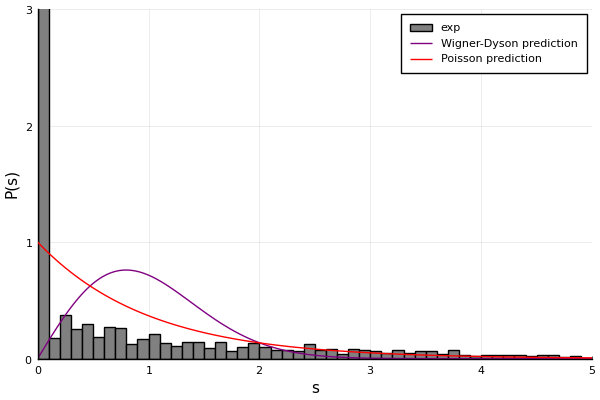

In [88]:
Energy_Spectrum=eigenstates(dense(H(0)))[1];
histogram(Spec_fil(Energy_Spectrum),label="exp",bins=0:0.1:5,normalize=:pdf,color=:gray)
plot!(WDdist,label="Wigner-Dyson prediction",color=:purple)
plot!(Poisson,label="Poisson prediction",color=:red)
xlims!(0, 5.0)
ylims!(0, 3)
title!("")
xlabel!("s")
ylabel!("P(s)")

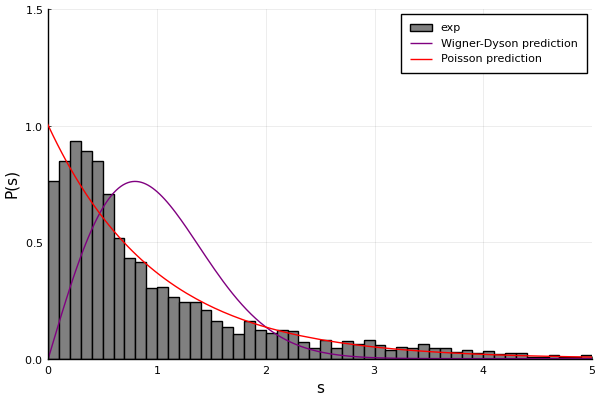

In [89]:
Energy_Spectrum=eigenstates(dense(H(0.02)))[1];
histogram(Spec_fil(Energy_Spectrum),label="exp",bins=0:0.1:5,normalize=:pdf,color=:gray)
plot!(WDdist,label="Wigner-Dyson prediction",color=:purple)
plot!(Poisson,label="Poisson prediction",color=:red)
xlims!(0, 5.0)
ylims!(0, 1.5)
title!("")
xlabel!("s")
ylabel!("P(s)")

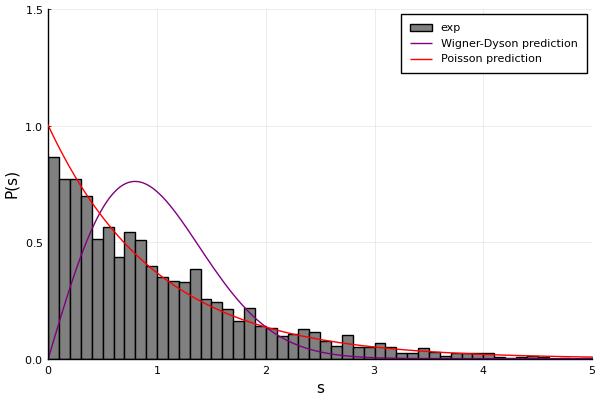

In [86]:
Energy_Spectrum=eigenstates(dense(H(0.2)))[1];
histogram(Spec_fil(Energy_Spectrum),label="exp",bins=0:0.1:5,normalize=:pdf,color=:gray)
plot!(WDdist,label="Wigner-Dyson prediction",color=:purple)
plot!(Poisson,label="Poisson prediction",color=:red)
xlims!(0, 5.0)
ylims!(0, 1.5)
title!("")
xlabel!("s")
ylabel!("P(s)")

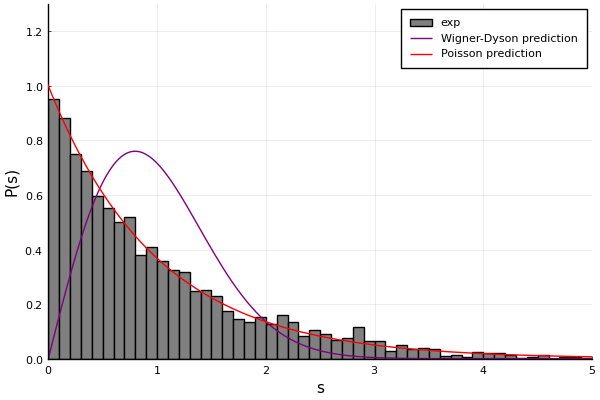

In [80]:
Energy_Spectrum=eigenstates(dense(H(0.96)))[1];
histogram(Spec_fil(Energy_Spectrum),label="exp",bins=0:0.1:5,normalize=:pdf,color=:gray)
plot!(WDdist,label="Wigner-Dyson prediction",color=:purple)
plot!(Poisson,label="Poisson prediction",color=:red)
xlims!(0, 5.0)
ylims!(0, 1.3)
title!("")
xlabel!("s")
ylabel!("P(s)")

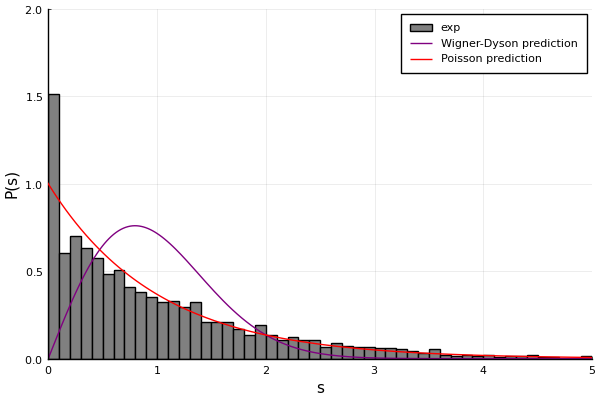

In [84]:
Energy_Spectrum=eigenstates(dense(H(1)))[1];
histogram(Spec_fil(Energy_Spectrum),label="exp",bins=0:0.1:5,normalize=:pdf,color=:gray)
plot!(WDdist,label="Wigner-Dyson prediction",color=:purple)
plot!(Poisson,label="Poisson prediction",color=:red)
xlims!(0, 5.0)
ylims!(0, 2)
title!("")
xlabel!("s")
ylabel!("P(s)")

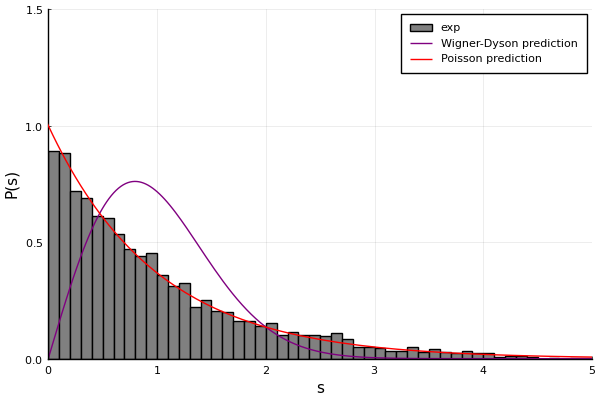

In [85]:
Energy_Spectrum=eigenstates(dense(H(1.5)))[1];
histogram(Spec_fil(Energy_Spectrum),label="exp",bins=0:0.1:5,normalize=:pdf,color=:gray)
plot!(WDdist,label="Wigner-Dyson prediction",color=:purple)
plot!(Poisson,label="Poisson prediction",color=:red)
xlims!(0, 5.0)
ylims!(0, 1.5)
title!("")
xlabel!("s")
ylabel!("P(s)")

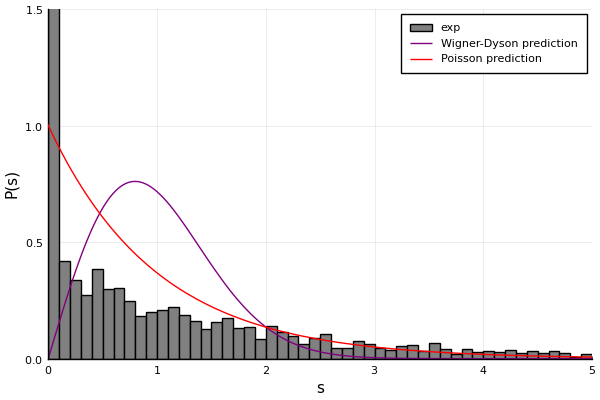

In [94]:
Energy_Spectrum=eigenstates(dense(H(15)))[1];
histogram(Spec_fil(Energy_Spectrum),label="exp",bins=0:0.1:5,normalize=:pdf,color=:gray)
plot!(WDdist,label="Wigner-Dyson prediction",color=:purple)
plot!(Poisson,label="Poisson prediction",color=:red)
xlims!(0, 5.0)
ylims!(0, 1.5)
title!("")
xlabel!("s")
ylabel!("P(s)")